In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [4]:
train_df = pd.read_csv('E:/Project/data/train.csv')
print(train_df.shape)

(3662, 2)


In [5]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


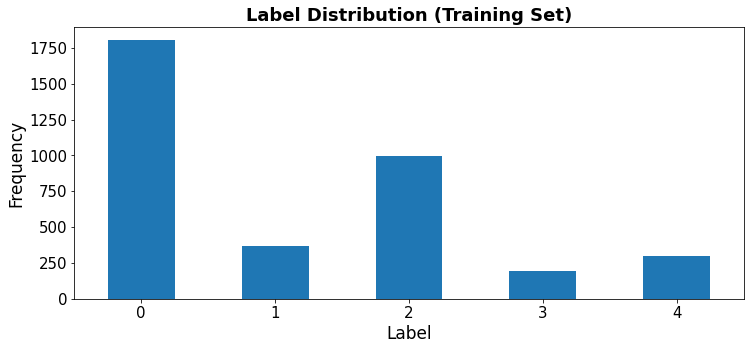

In [6]:
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [7]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

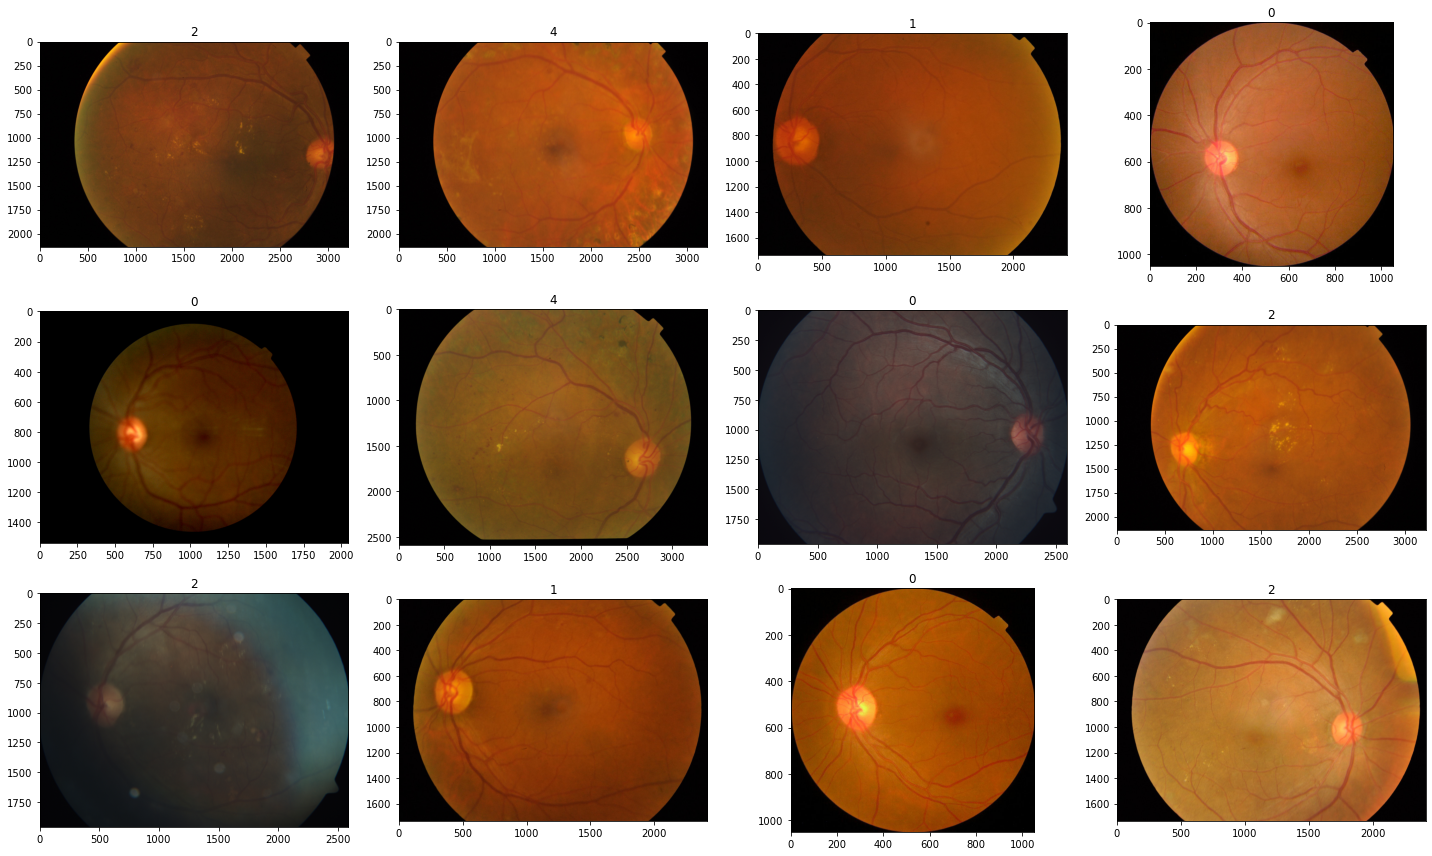

In [8]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'E:/Project/data/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [9]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [10]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'E:/Project/data/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [11:07<00:00,  5.49it/s]


In [11]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)

(3662, 224, 224, 3)
(3662, 5)


In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019
)

In [14]:
BATCH_SIZE = 8

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [15]:
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [16]:
densenet = DenseNet121(
    weights='E:/Project/DenseNet/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [17]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [18]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [19]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val)
)

C:\Users\himay\anaconda3\envs\PythonDL\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
389/389 [==============================] - 268s 483ms/step - loss: 0.3946 - accuracy: 0.5522 - val_loss: 0.1407 - val_accuracy: 0.8073
Epoch 2/20
389/389 [==============================] - 179s 460ms/step - loss: 0.1874 - accuracy: 0.7336 - val_loss: 0.1240 - val_accuracy: 0.8164
Epoch 3/20
389/389 [==============================] - 183s 471ms/step - loss: 0.1594 - accuracy: 0.7517 - val_loss: 0.1126 - val_accuracy: 0.7691
Epoch 4/20
389/389 [==============================] - 183s 469ms/step - loss: 0.1507 - accuracy: 0.8117 - val_loss: 0.1254 - val_accuracy: 0.8891
Epoch 5/20
389/389 [==============================] - 180s 463ms/step - loss: 0.1263 - accuracy: 0.8021 - val_loss: 0.0962 - val_accuracy: 0.7564
Epoch 6/20
389/389 [==============================] - 180s 464ms/step - loss: 0.1253 - accuracy: 0.8406 - val_loss: 0.0943 - val_accuracy: 0.8164
Epoch 7/20
389/389 [==============================] - 179s 459ms/step - loss: 0.1121 - accuracy: 0.8298 - val_loss: 0.0974 -

<AxesSubplot:>

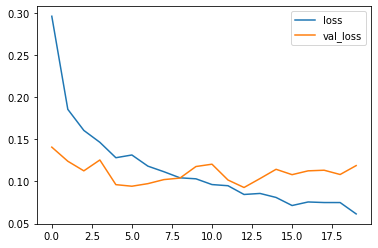

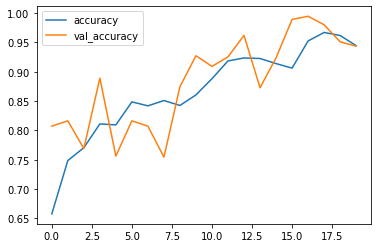

In [22]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [23]:
model.save('modelDR.h5')